In [27]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from transformers import AutoModel, BertTokenizer, BertTokenizerFast
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm
import csv
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import time

In [28]:
#Define custom dataset
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [29]:
class BertLSTM(nn.Module):
    def __init__(self, bert_model, lstm_hidden_dim, num_labels):
        super(BertLSTM, self).__init__()
        self.bert = bert_model
        self.bert.requires_grad_(False)  # Freeze BERT parameters
        self.lstm = nn.LSTM(bert_model.config.hidden_size, lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(lstm_hidden_dim * 2, num_labels)  # Correct dimension

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        cls_output = lstm_output[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

    

In [30]:
# Define Focal Loss 
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma, num_labels, reduction):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_labels = num_labels
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [31]:
# Record hyperparameters as csv
def write_hyperparameters(filepath, hyperparams):
    with open(filepath, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Hyperparameters'])
        for key, value in hyperparams.items():
            writer.writerow([key, value])
        writer.writerow([])
        # 在这里添加 'Learning Rate'
        writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Learning Rate'])


# Define hyperparameters
hyperparams = {
    'lstm_hidden_dim': 128,
    'max_len': 128,
    'batch_size': 8,
    'learning_rate': 0.0001,
    'num_epochs': 5,
    'alpha': 0.25,
    'gamma': 2.0,
    'reduction': 'mean'
}

In [33]:
import pickle

#Read data
df = pd.read_csv('../Web_scraping_and_Data_preproecssing/preprocessed_data.csv')
# Load the pre-trained BERT model and Tokenizer
#bert_model = AutoModel.from_pretrained('../Bert/FYP-Bert_model(multiple)')
#tokenizer = BertTokenizer.from_pretrained('../Bert/FYP-Bert_model(multiple)')

#bert_model = AutoModel.from_pretrained('../Bert/FYP-Bert_model(cn-only)')
#tokenizer = BertTokenizer.from_pretrained('../Bert/FYP-Bert_model(cn-only)')

bert_model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Generate label mapping
label_map = {label: i for i, label in enumerate(df['Classification'].unique())}
# Reverse mapping
reverse_label_map = {i: label for label, i in label_map.items()}

In [34]:
texts = df['Title_preprocessed'].tolist()
labels = [label_map[label] for label in df['Classification']]

# Stratified Sampling
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, stratify=labels, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5)


train_dataset = CustomTextDataset(X_train, y_train, tokenizer, max_len=hyperparams['max_len'])
val_dataset = CustomTextDataset(X_val, y_val, tokenizer, max_len=hyperparams['max_len'])
test_dataset = CustomTextDataset(X_test, y_test, tokenizer, max_len=hyperparams['max_len'])

#Create data loader
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])

In [35]:
# Create model
num_labels = len(df['Classification'].unique())
model = BertLSTM(bert_model, hyperparams['lstm_hidden_dim'], num_labels)

#Create device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [36]:
# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=hyperparams['learning_rate'])
criterion = FocalLoss(alpha=hyperparams['alpha'], gamma=hyperparams['gamma'], num_labels=num_labels, reduction=hyperparams['reduction'])
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
# CrossEntropyLoss function
#criterion = CrossEntropyLoss() 

In [37]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)
        
        progress_bar.set_postfix({'Loss': loss.item()})
    
    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    return average_loss, train_accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(predicted_labels == labels).item()
    average_loss = total_loss / len(loader)
    accuracy = correct_predictions / len(loader.dataset)
    return average_loss, accuracy

In [38]:
metrics_path = 'training_metrics(BertLSTM).csv'
write_hyperparameters(metrics_path, hyperparams)

num_epochs = hyperparams['num_epochs']
start_time = time.time()

best_val_loss = float('inf')  

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    # Get the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    
    # Update the learning rate after each epoch
    scheduler.step()

    # Record training metrics and current learning rate in CSV file
    with open(metrics_path, mode='a', newline='') as metrics_file:
        metrics_writer = csv.writer(metrics_file)
        metrics_writer.writerow([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy, current_lr])

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Learning Rate: {current_lr}')
    
    # Check if current validation loss is better than the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model weights
        torch.save(model, 'FYP_LSTM(multiple).pth')

end_time = time.time()
total_time = (end_time - start_time) / 60
print(f'Total training time: {total_time:.2f} minutes')

Training:   0%|          | 0/706 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.6203, Train Accuracy: 0.2570, Validation Loss: 0.5804, Validation Accuracy: 0.2945, Learning Rate: 0.0001


Training:   0%|          | 0/706 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.5728, Train Accuracy: 0.2884, Validation Loss: 0.5617, Validation Accuracy: 0.3085, Learning Rate: 0.0001


Training:   0%|          | 0/706 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.5558, Train Accuracy: 0.3086, Validation Loss: 0.5600, Validation Accuracy: 0.3242, Learning Rate: 0.0001


Training:   0%|          | 0/706 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.5453, Train Accuracy: 0.3127, Validation Loss: 0.5446, Validation Accuracy: 0.3400, Learning Rate: 0.0001


Training:   0%|          | 0/706 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.5341, Train Accuracy: 0.3258, Validation Loss: 0.5432, Validation Accuracy: 0.3284, Learning Rate: 0.0001
Total training time: 2.05 minutes


In [ ]:
# Set up 2-Fold cross validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cross-validation process
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):  
    train_texts = [X_train[i] for i in train_idx]
    train_labels = [y_train[i] for i in train_idx]
    valid_texts = [X_train[i] for i in valid_idx]
    valid_labels = [y_train[i] for i in valid_idx]

    train_subdataset = CustomTextDataset(train_texts, train_labels, tokenizer, max_len=hyperparams['max_len'])
    valid_subdataset = CustomTextDataset(valid_texts, valid_labels, tokenizer, max_len=hyperparams['max_len'])

    train_loader = DataLoader(train_subdataset, batch_size=hyperparams['batch_size'], shuffle=True)
    valid_loader = DataLoader(valid_subdataset, batch_size=hyperparams['batch_size'])

    model = BertLSTM(bert_model, hyperparams['lstm_hidden_dim'], len(set(labels))).to(device)
    optimizer = Adam(model.parameters(), lr=hyperparams['learning_rate'])
    #criterion = CrossEntropyLoss()
    criterion = FocalLoss(alpha=hyperparams['alpha'], gamma=hyperparams['gamma'], num_labels=num_labels, reduction=hyperparams['reduction'])
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


    for epoch in range(hyperparams['num_epochs']):
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)
        scheduler.step()

        print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')


In [ ]:
# Grid search 
param_grid = {
    'lstm_hidden_dim': [64, 128],
    'batch_size': [8, 16],
    'learning_rate': [0.001, 0.0001],
    'alpha': [0.25, 0.50],
    'gamma': [1.0, 2.0],
    'max_len': [128, 256]  
}
grid = ParameterGrid(param_grid)

best_model = None
best_accuracy = 0
best_params = None

for params in grid:
    print("Testing configuration:", params)
    train_dataset = CustomTextDataset(X_train, y_train, tokenizer, max_len=params['max_len'])
    test_dataset = CustomTextDataset(X_test, y_test, tokenizer, max_len=params['max_len'])
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    valid_loader = DataLoader(test_dataset, batch_size=params['batch_size'])

    model = BertLSTM(bert_model, params['lstm_hidden_dim'], len(set(labels))).to(device)
    optimizer = Adam(model.parameters(), lr=params['learning_rate'])
    criterion = FocalLoss(alpha=params['alpha'], gamma=params['gamma'], num_labels=len(set(labels)), reduction='mean')
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    fold_acc = []
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
        # Cross Validation
        train_texts = [X_train[i] for i in train_idx]
        train_labels = [y_train[i] for i in train_idx]
        valid_texts = [X_train[i] for i in valid_idx]
        valid_labels = [y_train[i] for i in valid_idx]

        # Initialize the dataset
        train_subdataset = CustomTextDataset(train_texts, train_labels, tokenizer, max_len=params['max_len'])
        valid_subdataset = CustomTextDataset(valid_texts, valid_labels, tokenizer, max_len=params['max_len'])

        train_loader = DataLoader(train_subdataset, batch_size=params['batch_size'], shuffle=True)
        valid_loader = DataLoader(valid_subdataset, batch_size=params['batch_size'])

        for epoch in range(3):  #Adjust the number of epochs as needed
            train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
            valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)
            scheduler.step()

            print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')
        
        fold_acc.append(valid_accuracy)

    avg_accuracy = sum(fold_acc) / len(fold_acc)
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_model = model
        best_params = params

print("Best Accuracy:", best_accuracy)
print("Best Params:", best_params)

In [ ]:
# Save the entire model 
model_save_path = 'FYP_LSTM(multiple).pth'
torch.save(model, model_save_path)

In [ ]:
# Test the model
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [ ]:
import json

label_map_path = 'label_map.json'
with open(label_map_path, 'w') as file:
    json.dump(label_map, file)

print(f"Label map saved to {label_map_path}")

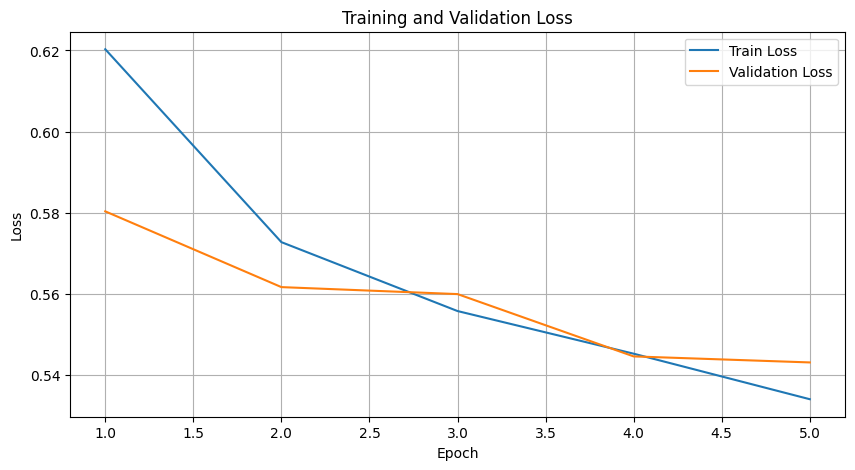

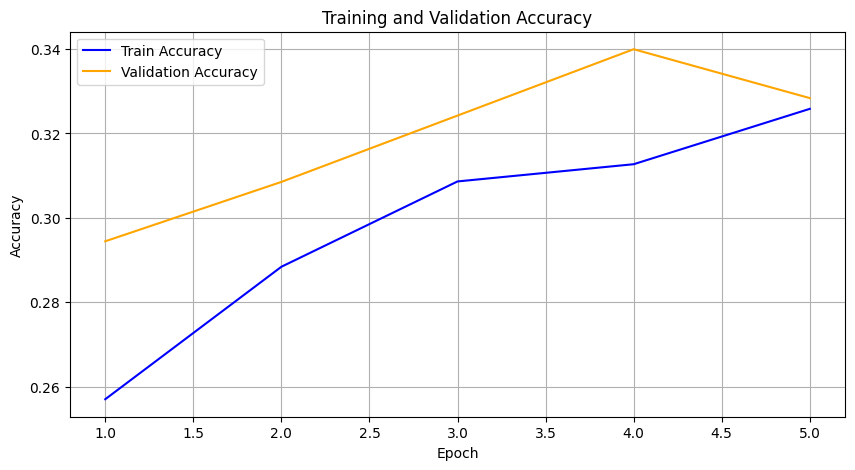

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

#Read performance metrics csv file
df = pd.read_csv('training_metrics(BertLSTM).csv',header=9)

# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Draw model accuracy
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy', color='blue')
plt.plot(df['Epoch'], df['Validation Accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()